In [3]:
import numpy as np
import pandas as pd

data = pd.read_csv('./loan_data_track1.csv')

In [4]:
data.columns

Index(['checking_status', 'duration', 'loan_history', 'purpose', 'loan_amount',
       'savings_status', 'employment', 'installment_commitment',
       'personal_status', 'other_parties', 'residence_since',
       'property_magnitude', 'age', 'other_payment_plans', 'housing',
       'existing_loans', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'accepted'],
      dtype='object')

In [5]:
# Replace label values from (2,1) to (1,0)
data['accepted'] = data['accepted'] - 1

In [8]:
# Check the inbalance of labels
data.accepted.value_counts()

1    700
0    300
Name: accepted, dtype: int64

In [7]:
# Extracting integers from string 
data['existing_loans'] = data['existing_loans'].str.extract('(\d+)').astype(int)

# Choose major variables
df = data[['age', 'checking_status','duration','loan_amount','installment_commitment']]

# Get dummies for categorical variable
dummy = pd.get_dummies(df['checking_status'])

df = pd.concat([df,dummy], axis=1)

df = df.drop('checking_status', axis=1)

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer, accuracy_score

train_labels = np.array(data['accepted'])
train_set = df
train_set.columns = ['age','duration','loan_amount','installment_commitment','Mid','Low','High','None']

# Train Random Forest Classifier as a baseline 
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(train_set, train_labels)

# Set performance metric to f1 score (instead of accuracy)
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

# Perform 10-fold cross validation and print mean and std of 10 f1 scores
cv_score = cross_val_score(model, train_set, train_labels, cv = 10, scoring = scorer)
print('F1 Score = Mean: %f, Std: %f' % (cv_score.mean() , cv_score.std()))

F1 Score = Mean: 0.642099, Std: 0.079672


In [37]:
# Check the importance of features
feature = train_set.columns
feature_imoportances = pd.DataFrame({'feature': feature, 'importance': model.feature_importances_})
feature_imoportances.sort_values('importance', ascending=False)

,feature,importance
2,loan_amount,0.356470
0,age,0.260708
1,duration,0.176358
3,installment_commitment,0.068729
7,None,0.068027
5,Low,0.042153
4,Mid,0.018534
6,High,0.009022


During Interview

======================

After Interview 


In [56]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring=scorer, n_jobs = -1)
    print(name + f' 10 Fold CV Score: {round(cv_scores.mean(),4)} with std: {round(cv_scores.std(),4)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                            'cv_std': cv_scores.std()},
                                                           index = [0]),
                                             ignore_index = True)

        return model_results


In [57]:
model_results = cv_model(train_set, train_labels, LinearSVC(),'LSVC', model_results)

# Gaussian Naive Bayes Classifier is our current winner 
model_results = cv_model(train_set, train_labels, GaussianNB(priors=None, var_smoothing=1e-09), 'GNB', model_results)

# As anticipated nonlinear model like multi-layer perceptron itself, shows inferior performance 
model_results = cv_model(train_set, train_labels, MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                         'MLP', model_results)

model_results = cv_model(train_set, train_labels, LinearDiscriminantAnalysis(),'LDA', model_results)
model_results = cv_model(train_set, train_labels, RidgeClassifierCV(), 'RIDGE', model_results)

for n in [5, 10, 20]:
    print(f'\nKNN with {n} neighbors\n')
    model_results = cv_model(train_set, train_labels, KNeighborsClassifier(n_neighbors = n), f'knn-{n}', model_results)

model_results = cv_model(train_set, train_labels, ExtraTreesClassifier(n_estimators = 100, random_state = 10),
                         'EXT', model_results)

model_results = cv_model(train_set, train_labels,RandomForestClassifier(100, random_state=10),
                         'RF', model_results)


LSVC 10 Fold CV Score: 0.4621 with std: 0.0712
GNB 10 Fold CV Score: 0.6735 with std: 0.0486
MLP 10 Fold CV Score: 0.4119 with std: 0.0789
LDA 10 Fold CV Score: 0.6479 with std: 0.0518
RIDGE 10 Fold CV Score: 0.6003 with std: 0.0693

KNN with 5 neighbors

knn-5 10 Fold CV Score: 0.5301 with std: 0.0335

KNN with 10 neighbors

knn-10 10 Fold CV Score: 0.5214 with std: 0.0583

KNN with 20 neighbors

knn-20 10 Fold CV Score: 0.4954 with std: 0.0492
EXT 10 Fold CV Score: 0.6125 with std: 0.0698
RF 10 Fold CV Score: 0.6345 with std: 0.0894


In [58]:
# Now we try the XGBoost classifier 
# I manually tuned some hyperparameters a little
from xgboost import XGBClassifier

model_results = cv_model(train_set, train_labels,
                          XGBClassifier(
                               learning_rate =0.01,
                               n_estimators=1000,
                               max_depth=4,
                               min_child_weight=1,
                               gamma=0.1,
                               subsample=0.6,
                               colsample_bytree=0.8,
                               objective= 'binary:logistic',
                               scale_pos_weight=0.5,
                               seed=10),
                              'XGB', model_results)


XGB 10 Fold CV Score: 0.7007 with std: 0.057


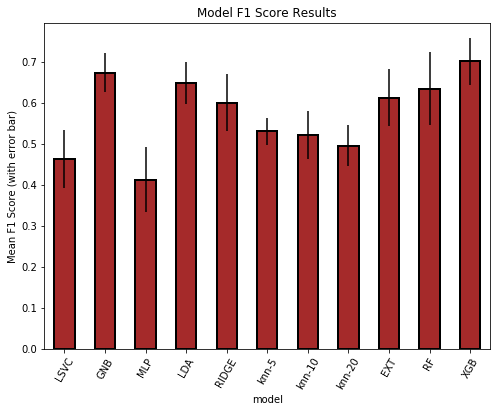

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Plot a graph comparing the model performance 
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'brown', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results')
plt.ylabel('Mean F1 Score (with error bar)')
plt.xticks(rotation=60)
model_results.reset_index(inplace = True)

In [60]:
# Why not we use the rest of the features?
# Also make dummies out of given categorical variable
dummy1 = pd.get_dummies(data['personal_status'])
dummy2 = pd.get_dummies(data['employment']) 
dummy3 = pd.get_dummies(data['housing'])
dummy4 = pd.get_dummies(data['job'])
df = pd.concat([df,dummy1,dummy2,dummy3,dummy4], axis=1)

mapping1 = {'Yes':1, 'No':0}
mapping2 = {'yes':1, 'no':0}

additional = data[['residence_since','existing_loans','own_telephone','foreign_worker']]
additional = additional.replace(mapping1)
additional = additional.replace(mapping2)
df = pd.concat([df, additional],axis=1)

df.columns = ['age', 'duration', 'loan_amount', 'installment_commitment',
       'Mid', 'Low', 'High', 'None',
       'female_divorced/separated/married', 'male_divorced/separated',
       'male_married/widowed', 'male_single', 'term2', 'term3', 'term1',
       'term4', 'unemployed_A', 'for_free', 'own', 'rent',
       'highly_qualified',
       'skilled', 'unemployed',
       'unskilled_resident', 'residence_since', 'existing_loans',
       'own_telephone', 'foreign_worker']
train_set = df

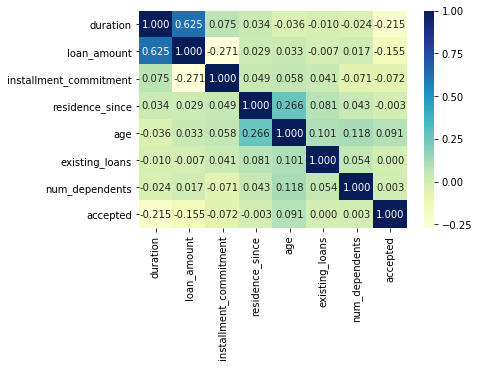

In [73]:
import seaborn as sns

threshold = 0.9

# Create correlation matrix
corr_matrix = data.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(abs(upper[column]) > threshold)]

data = data.drop(columns = to_drop)

# Show the correlation of each pair of featues
sns.heatmap(corr_matrix,annot=True, cmap = plt.cm.YlGnBu, fmt='.3f')

In [75]:
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE

n_components = 3

# Make extra features with dimension reduction 
# This might not be a good idea for this dataset because there are not much redundancy within it 
pca = PCA(n_components=n_components)
ica = FastICA(n_components=n_components)
tsne = TSNE(n_components=n_components) 
train_df = train_set.copy()

for method, name in zip([pca, ica, tsne], 
                        ['pca', 'ica', 'tsne']):
    
    # TSNE has no transform method
    if name == 'tsne':
        reduction = method.fit_transform(train_df)
    
    else:
        reduction = method.fit_transform(train_df)
        

    # Add components to training data for visualization and modeling
    train_df['%s_c1' % name] = reduction[:, 0]
    train_df['%s_c2' % name] = reduction[:, 1]
    train_df['%s_c3' % name] = reduction[:, 2]

In [77]:
# The performance has become worse after putting more features 
model_results = cv_model(train_df, train_labels,
                          XGBClassifier(
                               learning_rate =0.01,
                               n_estimators=1000,
                               max_depth=4,
                               min_child_weight=1,
                               gamma=0.1,
                               subsample=0.6,
                               colsample_bytree=0.8,
                               objective= 'binary:logistic',
                               scale_pos_weight=0.5,
                               seed=10),
                              'XGB', model_results)


XGB 10 Fold CV Score: 0.6753 with std: 0.0535
